# Pre-Experiment
Define All Variables to Run the Experiment
    <p>```setup.bash``` Exports the Variables to a ```setup.conf``` and sends it to the server</p>

In [1]:
username=sgt43 # Username of user on server
exp_name=dsef-janus # Name of Experiment on TestBed
proj_name=cops # Name of Project on TestBed
default_node=node-0 # Default node to run the experiment from
ds=cops2
host_ip=users.emulab.net
host_servers_ip=emulab.net
default_ip=${default_node}.${exp_name}.${proj_name}.${host_servers_ip}
proj_path=/home/sgt43/DSEF

# Setup Number of Servers and Clients
nservers=2 # Number of Servers and Clients
ndcs=2 # Number of Data Centers
eindex=0
ipprefix="node-"
ippostfix=""
threads=1
replication_factor=$ndcs

# Initialize Consistent Variables
trial=1 # Number of Trials in the Experiment
nkeys=10000 # Number of keys for the Experiment
run_time=10 # Time to run the Expierment
trim=1 # Trimmed time from the gathered results

# Initialize Default Variables
value_size=128 # Size of the Value Read and/or Written
cols_per_key_read=5 # Columns per key read
cols_per_key_write=5 # Columns per key write
keys_per_read=5 # Keys per read
keys_per_write=5 # Keys per write
write_frac="0.1" # Fraction of Write Operations to Read Operations
write_trans_frac="0.5" # Fraction of Write Transcation to Read Transactions

# Specify the Experiment's Indepdent Variable and its Values
exp=keys_per_read # Name of the Experiment
indep_values="1:${nkeys}" # Independent Variables to be Experimented with

insert_cmd=INSERTCL
KILLALL_SSH_TIME=90
MAX_ATTEMPTS=10

alias emulab="ssh ${username}@${host_ip} -o StrictHostKeyChecking=no"
alias server="ssh ${username}@${host_ip} -o StrictHostKeyChecking=no ssh ${default_ip} -t -t -o StrictHostKeyChecking=no"

source ${proj_path}/setup.bash

setup.conf
            424 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=0/1)
dynamic_common.bash
          7,280 100%    6.28MB/s    0:00:00 (xfr#1, to-chk=0/1)
kodiak_dc_launcher.bash
          4,853 100%    3.96MB/s    0:00:00 (xfr#1, to-chk=0/1)


# Experiment
Launch Instances of the Distributed System
    
Setup Benchmark on Clients
    
Start the Experiment
    
Kill all Instances of the Distributed System

In [2]:
# emulab "/usr/testbed/bin/node_reboot -w -e ${proj_name},${exp_name}"

server <<- 'EOF'

source dynamic_common.bash

nserverstotal=$((ndcs*nservers))

init

for t in $(seq $trial); do
for i in $(seq 0 $((${#var[@]} - 1))); do

    kill_all_ds
        
    setup

    launch
    
    set_server_keyspace
    
    set_client_keyspace
        
    for (( j = 1; j<=$((nserverstotal)); j++)); do
        ssh -o StrictHostKeyChecking=no ${ipprefix}${j} "collectl -P -ou -R $((run_time+20))s -f/tmp/${ds}_${t}" &
    done
    
    run_experiment
    
    kill_all_ds
    
    gather_results
    
    for (( j = 1; j<=$((nserverstotal)); j++)); do
        rsync --remove-source-files -az ${ipprefix}${j}:/tmp/${ds}* ${output_dir}
    done
    
done; done; exit; exit;
EOF

# get latest data from server and rearrange it to a timestamped format

rm -rf ${proj_path}/runs/latest # delete old link

rsync -az --copy-links ${username}@${host_ip}:/users/${username}/${ds}/experiments/dynamic_${exp}/latest ${proj_path}/runs

cd ${proj_path}/runs
timestamp=$(date +%s)
mv latest ${timestamp}
ln -s ${timestamp} latest

cd latest
mkdir data
for i in $(ls *.gz); do
    mv ${i} ./data/
    gunzip ./data/${i}
done


source dynamic_common.bash

nserverstotal=$((ndcs*nservers))

init

for t in $(seq $trial); do
for i in $(seq 0 $((${#var[@]} - 1))); do

    kill_all_ds
        
    setup

    launch
    
    set_server_keyspace
    
    set_client_keyspace
        
    for (( j = 1; j<=$((nserverstotal)); j++)); do
        ssh -o StrictHostKeyChecking=no ${ipprefix}${j} "collectl -P -ou -R $((run_time+20))s -f/tmp/${ds}_${t}" &
    done
    
    run_experiment
    
    kill_all_ds
    
    gather_results
    
    for (( j = 1; j<=$((nserverstotal)); j++)); do
        rsync --remove-source-files -az ${ipprefix}${j}:/tmp/${ds}* ${output_dir}
    done
    
done; done; exit; exit;
Welcome to Ubuntu 16.04.1 LTS (GNU/Linux 4.4.0-45-generic x86_64)

 * Documentation:  https://help.ubuntu.com
 * Management:     https://landscape.canonical.com
 * Support:        https://ubuntu.com/advantage
Last login: Thu Jun  1 13:35:23 2017 from 155.98.33.74
sgt43@node-0:~$ 
sgt43@node-0:~$ source dynamic_common.bash
sgt

[7]+  Done                    ssh $client -o StrictHostKeyChecking=no "cd ${src_dir}/tools/stress; 	    	((bin/stress --progress-interval=1 --nodes=$local_servers_csv --operation=DYNAMIC 	    	--consistency-level=LOCAL_QUORUM --replication-strategy=NetworkTopologyStrategy 	    	--strategy-properties=$strategy_properties --num-different-keys=$keys --stress-index=$index 	    	--stress-count=$num_nodes_per_dc --num-keys=20000000 --column-size=$value_size 	    	--columns-per-key-read=$cols_per_key_read --columns-per-key-write=$cols_per_key_write 	    	--keys-per-read=$keys_per_read --keys-per-write=$keys_per_write --write-fraction=$write_frac 	    	--write-transaction-fraction=$write_trans_frac --threads=$threads 	    	 > >(tee ${cli_output_dir}/${data_file_name}) 	    	2> ${cli_output_dir}/${data_file_name}.stderr) &); 	    	sleep $((run_time+10)); ${src_dir}/kill_stress_kodiak.bash" 2>&1 | awk '{ print "'$client': "$0 }'
Connection to node-1 closed.
Connection to node-2 closed.
logout
Co

# Data Gathering and Post Processing
Gather Data from Servers and Clients
    
Post Process the Data into Meaningful Chunks
    
Generate Graphs from the Data Chuncks

In [7]:
output_dir=${proj_path}/runs/latest

source ${proj_path}/setup.conf
export ds # needed in postprocessing scripts

cd ${proj_path}/postprocess
./dynamic_postprocess_full.bash ${output_dir} ${output_dir} ${run_time} ${trim} shuffle

# remove trials
echo "Removing old trials"
rm -rf ${output_dir}/trial*

client0
  cops2/
    trial1/
done shuffling
  Client Postprocess: complete     
  Combining Clients: complete      1_5_0.1_0.5_10+1+tput      
/home/sgt43/DSEF/runs/latest/cops2.graph
1	218	307	1536	194920
Removing old trials


# Graphing with GNUPlot

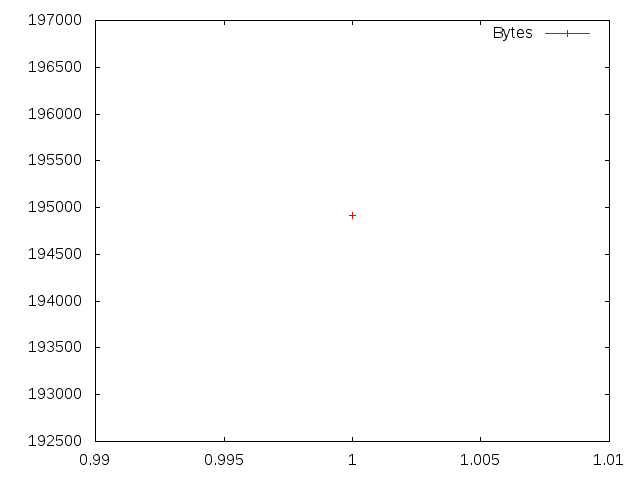

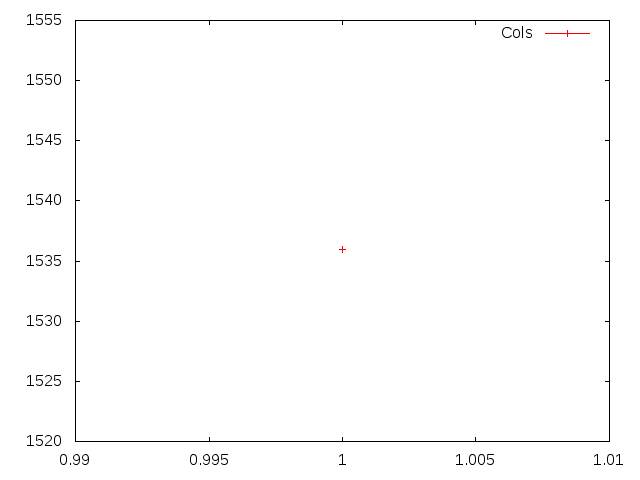

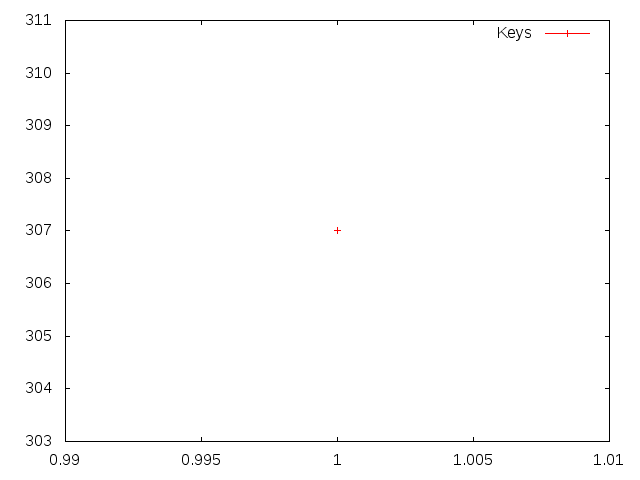

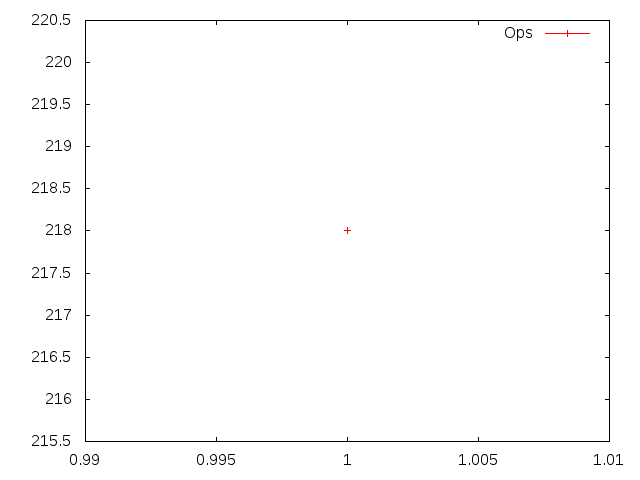

In [8]:
cd ${proj_path}/runs/latest

source ${proj_path}/setup.conf
export ds

gnuplot <<- 'EOF'

    ds=system("echo ${ds}")
    
    set term png

    set output "bytes.png"
    plot ds.".graph" using 1:5 with linespoint title 'Bytes'

    set output "cols.png"
    plot ds.".graph" using 1:4 with linespoint title 'Cols'

    set output "keys.png"
    plot ds.".graph" using 1:3 with linespoint title 'Keys'

    set output "ops.png"
    plot ds.".graph" using 1:2 with linespoint title 'Ops'

EOF

display < bytes.png
display < cols.png
display < keys.png
display < ops.png

rm *.png